Text(0.5, 1.0, 'Original image')

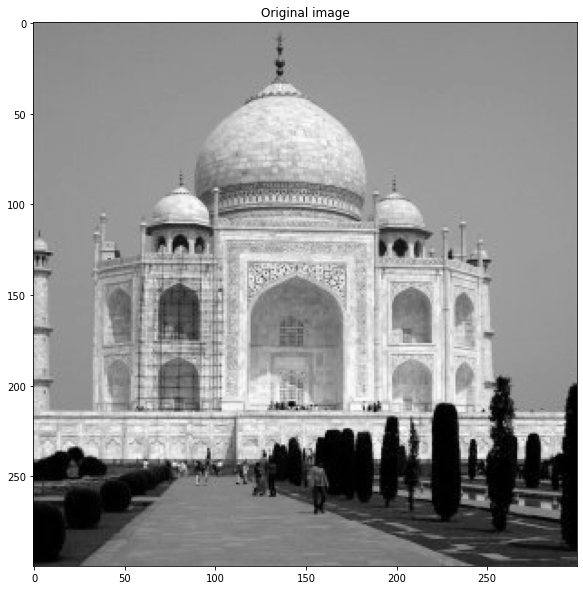

In [ ]:
%matplotlib inline
from IPython.display import display, Math, Latex
from skimage import data, feature, color, img_as_float, filters
import math
import numpy as np
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

#url = 'https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png'

url = 'https://docs.gimp.org/2.8/en/images/filters/examples/taj_orig.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert('L')

# display the image
figsize = (10,10)
plt.figure(figsize=figsize)

plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title("Original image")


In [ ]:
class Filtering:
    image = None
    filter = None
    cutoff = None
    order = None

    def __init__(self, image, filter_name, cutoff, order=0):
        self.image = image
        if filter_name == 'ideal_l':
            self.filter = self.get_ideal_low_pass_filter
        elif filter_name == 'ideal_h':
            self.filter = self.get_ideal_high_pass_filter
        elif filter_name == 'butterworth_l':
            self.filter = self.get_butterworth_low_pass_filter
        elif filter_name == 'butterworth_h':
            self.filter = self.get_butterworth_high_pass_filter
        elif filter_name == 'gaussian_l':
            self.filter = self.get_gaussian_low_pass_filter
        elif filter_name == 'gaussian_h':
            self.filter = self.get_gaussian_high_pass_filter

        self.filter_name = filter_name
        self.cutoff = cutoff
        self.order = order


    def get_ideal_low_pass_filter(self, shape, cutoff):
        d0 = cutoff
        rows, columns = shape
        mask = np.zeros((rows, columns), dtype=int)
        mid_R, mid_C = int(rows/2), int(columns/2)
        for i in range(rows):
            for j in range(columns):
                d = math.sqrt((i - mid_R)**2 + (j - mid_C)**2)
                if d <= d0:
                    mask[i, j] = 1
                else:
                    mask[i, j] = 0

        return mask


    def get_ideal_high_pass_filter(self, shape, cutoff):
        d0 = cutoff
        mask = 1 - self.get_ideal_low_pass_filter(shape, d0)
        
        return mask

    def get_butterworth_low_pass_filter(self, shape, cutoff, order):
        d0 = cutoff
        n = order
        rows, columns = shape
        mask = np.zeros((rows, columns))
        mid_R, mid_C = int(rows / 2), int(columns / 2)
        for i in range(rows):
            for j in range(columns):
                d = math.sqrt((i - mid_R) ** 2 + (j - mid_C) ** 2)
                mask[i, j] = 1 / (1 + (d / d0) ** (2 * n))

        return mask

    def get_butterworth_high_pass_filter(self, shape, cutoff, order):
        d0 = cutoff
        n = order
        rows, columns = shape
        mask = np.zeros((rows, columns))
        mid_R, mid_C = int(rows / 2), int(columns / 2)
        for i in range(rows):
            for j in range(columns):
                d = math.sqrt((i - mid_R) ** 2 + (j - mid_C) ** 2)
                if d == 0:
                    mask[i, j] = 0
                else:
                    mask[i, j] = 1 / (1 + (d0 / d) ** (2 * n))
        
        return mask

    def get_gaussian_low_pass_filter(self, shape, cutoff):
        d0 = cutoff
        rows, columns = shape
        mask = np.zeros((rows, columns))
        mid_R, mid_C = int(rows / 2), int(columns / 2)
        for i in range(rows):
            for j in range(columns):
                d = math.sqrt((i - mid_R) ** 2 + (j - mid_C) ** 2)
                mask[i, j] = np.exp(-(d * d) / (2 * d0 * d0))

        return mask

    def get_gaussian_high_pass_filter(self, shape, cutoff):
        d0 = cutoff
        mask = 1 - self.get_gaussian_low_pass_filter(shape, d0)
        
        return mask

    def post_process_image(self, image):
        a = 0
        b = 255
        c = np.min(image)
        d = np.max(image)
        rows, columns = np.shape(image)
        image1 = np.zeros((rows, columns), dtype=int)
        for i in range(rows):
            for j in range(columns):
                if (d-c) == 0:
                    image1[i, j] = ((b - a) / 0.000001) * (image[i, j] - c) + a
                else:
                    image1[i, j] = ((b - a) / (d - c)) * (image[i, j] - c) + a

        return np.uint8(image1)


    def filtering(self):
        image = self.image
        cutoff = self.cutoff
        order = self.order
        filter_name = self.filter_name
        shape = np.shape(image)

        fft = np.fft.fft2(image)

        shift_fft = np.fft.fftshift(fft)
        mag_dft = np.log(np.abs(shift_fft))
        dft = self.post_process_image(mag_dft)

        if filter_name == 'butterworth_l' or filter_name == 'butterworth_h':
            mask = self.filter(shape, cutoff, order)
        else:
            mask = self.filter(shape, cutoff)

        filtered_image = np.multiply(mask, shift_fft)
        mag_filtered_dft = np.log(np.abs(filtered_image)+1)
        filtered_dft = self.post_process_image(mag_filtered_dft)
        shift_ifft = np.fft.ifftshift(filtered_image)

        ifft = np.fft.ifft2(shift_ifft)

        mag = np.abs(ifft)

        filtered_image = self.post_process_image(mag)
        
        return [np.uint8(filtered_image), np.uint8(dft), np.uint8(filtered_dft)]

Text(0.5, 1.0, 'Discrete Fourier Transform')

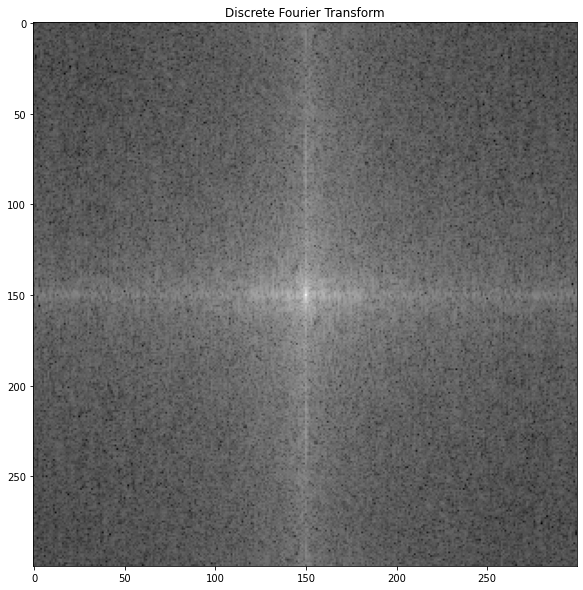

In [ ]:
# Ideal Low Pass Filtering
mask = 'ideal_l'
cutoff_f = 30
order = 5

Filter_obj = Filtering(img, mask, cutoff_f, order)
ideal_output = Filter_obj.filtering()

# Display Discrete Fourier Transform
figsize = (10,10)
plt.figure(figsize=figsize)

plt.imshow(ideal_output[1], cmap='gray', vmin=0, vmax=255)
plt.title("Discrete Fourier Transform")

Text(0.5, 1.0, 'Ideal Low Pass Filtering')

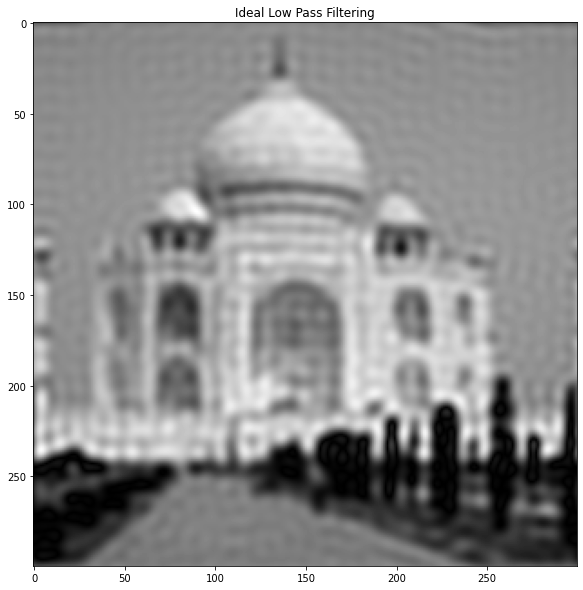

In [ ]:
# Display the output image
figsize = (10,10)
plt.figure(figsize=figsize)

plt.imshow(ideal_output[0], cmap='gray', vmin=0, vmax=255)
plt.title("Ideal Low Pass Filtering")

Text(0.5, 1.0, 'Discrete Fourier Transform')

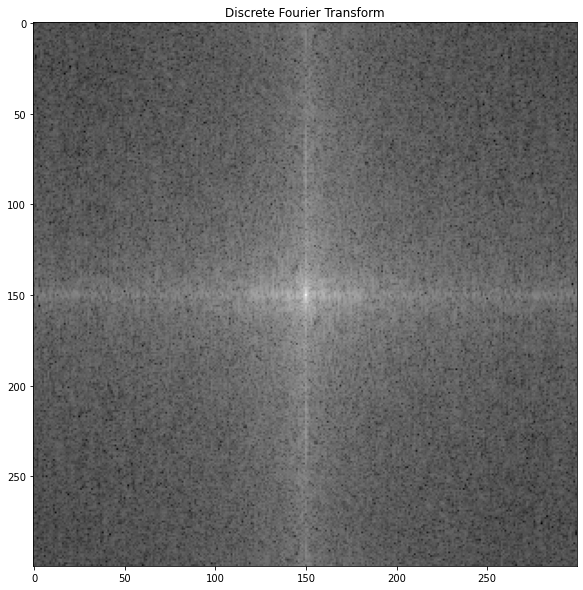

In [ ]:
# Butterworth Low Pass Filtering
mask = 'butterworth_l'
cutoff_f = 30
order = 5

Filter_obj = Filtering(img, mask, cutoff_f, order)
butterworth_output = Filter_obj.filtering()

# Display Discrete Fourier Transform
figsize = (10,10)
plt.figure(figsize=figsize)

plt.imshow(butterworth_output[1], cmap='gray', vmin=0, vmax=255)
plt.title("Discrete Fourier Transform")


Text(0.5, 1.0, 'Butterworth Low Pass Filtering')

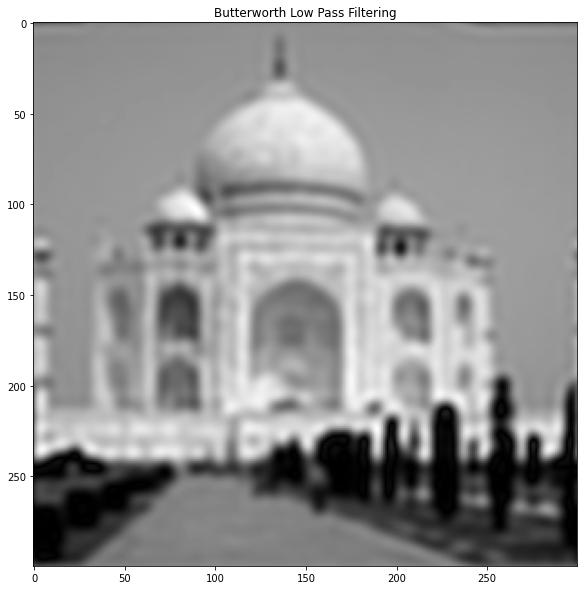

In [ ]:
# display the image
figsize = (10,10)
plt.figure(figsize=figsize)

plt.imshow(butterworth_output[0], cmap='gray', vmin=0, vmax=255)
plt.title("Butterworth Low Pass Filtering")

Text(0.5, 1.0, 'Discrete Fourier Transform')

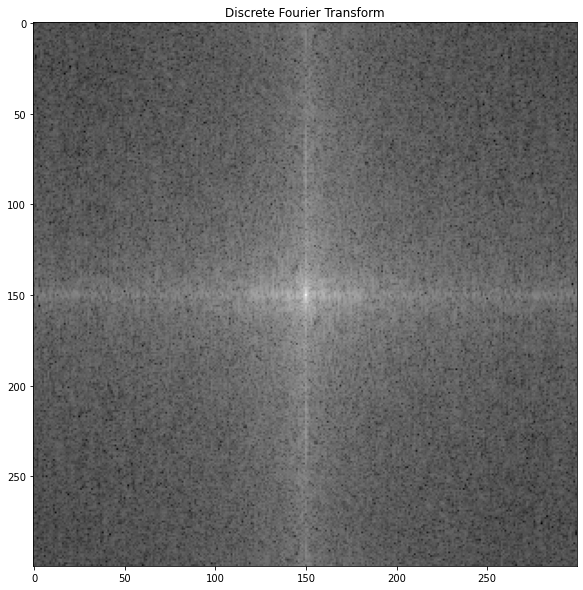

In [ ]:
# Gaussian Low Pass Filtering
mask = 'gaussian_l'
cutoff_f = 30
order = 5

Filter_obj = Filtering(img, mask, cutoff_f, order)
gaussian_output = Filter_obj.filtering()

# Display Discrete Fourier Transform
figsize = (10,10)
plt.figure(figsize=figsize)

plt.imshow(gaussian_output[1], cmap='gray', vmin=0, vmax=255)
plt.title("Discrete Fourier Transform")

Text(0.5, 1.0, 'Gaussian Low Pass Filtering')

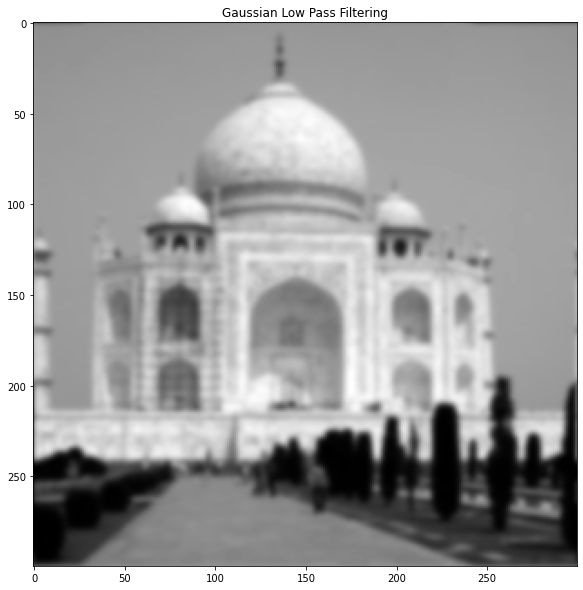

In [ ]:
# Display the output image
figsize = (10,10)
plt.figure(figsize=figsize)

plt.imshow(gaussian_output[0], cmap='gray', vmin=0, vmax=255)
plt.title("Gaussian Low Pass Filtering")